In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import time
import pandas as pd

In [3]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return {'img':img, 'box':[int(i) for i in box * scale]}

In [4]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [5]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [6]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [7]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [8]:
def style_content_loss(outputs, style_targets, content_targets, num_style_layers, num_content_layers, style_weight, content_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]
    return x_var, y_var

def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

def face_content_loss(outputs, style_targets, content_targets, num_style_layers, num_content_layers, style_weight, content_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [9]:
def convert(epochs, steps_per_epoch, content_weight, total_variation_weight, style_path, content_path, box, content_layers, style_layers):
    style_weight = 1
    content_image = load_img(content_path)['img']
    style_image = load_img(style_path)['img']
    box = load_img(style_path)['box']
    num_content_layers = len(content_layers)
    num_style_layers = len(style_layers)
    extractor = StyleContentModel(style_layers, content_layers)
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']
    opt = tf.optimizers.Adam(learning_rate=0.1, beta_1=0.99, epsilon=1e-1)
    image = tf.Variable(content_image)
    @tf.function()
    def train_step(image, box, extractor, style_targets, content_targets, num_style_layers, num_content_layers, style_weight, content_weight, total_variation_weight, opt):
        with tf.GradientTape() as tape:
            outputs = extractor(image)
            loss = style_content_loss(outputs, style_targets, content_targets, num_style_layers, num_content_layers, style_weight, content_weight)
            loss += total_variation_weight*tf.image.total_variation(image[:, box[1]:(box[1]+box[3]), box[0]:(box[0] + box[2]), :])
        grad = tape.gradient(loss, image)
        opt.apply_gradients([(grad, image)])
        image.assign(clip_0_1(image))

    step = 0
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            train_step(image, box, extractor, style_targets, content_targets, num_style_layers, num_content_layers, style_weight, content_weight, total_variation_weight, opt)
            print(".", end='')
        display.clear_output(wait=True)
        display.display(tensor_to_image(image))
        print("Train step: {}".format(step))
    return(tensor_to_image(image))

# Set up parameters

In [ ]:
#####
style_path = 'Data\\s_1_crop.png'
content_path = 'Data\\c_1_crop.png'
box = [192, 151, 92, 122]
epochs = 20
steps_per_epoch = 100
content_weight = 100000 
total_variation_weight = 300

# Pick structure

In [ ]:
#####
content_layers_all = ['block1_conv2',
                'block2_conv2',
                'block3_conv2', 
                'block4_conv2', 
                'block5_conv2'] 
style_layers_all = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
for n_slyle_layers in np.arange(1):
    for num_content_layers in np.arange(1,6):
        img = convert(epochs, steps_per_epoch, content_weight, total_variation_weight, style_path, content_path, box, [content_layers_all[num_content_layers]], style_layers_all[:n_slyle_layers])
        img.save('Results\\Structure\\1_nsl_'+str(n_slyle_layers)+'_numcl_'+str(num_content_layers)+'.png')

# Optimal structure

In [ ]:
#######
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

# Pick weights

In [ ]:
#######
for content_weight in 10**(np.arange(3,7)):
    for total_variation_weight in np.append(0, 3*10**np.arange(1,4)):
        img = convert(epochs, steps_per_epoch, content_weight, total_variation_weight, style_path, content_path, box, content_layers, style_layers)
        img.save('Results\\Weights\\1_cw_'+str(content_weight)+'_tvw_'+str(total_variation_weight)+'.png')

# Optimal weights

In [10]:
content_weight = 10**6
total_variation_weight = 3*10**3

# Check results

In [ ]:
epochs = 50
steps_per_epoch = 100

## IOU alignment

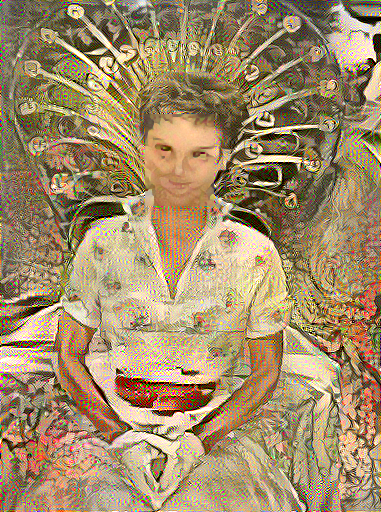

Train step: 5000


In [15]:
style_path = 'Data\\s_1_crop.png'
content_path = 'Data\\c_1_crop.png'
box = [192, 151, 92, 122]
img = convert(epochs, steps_per_epoch, content_weight, total_variation_weight, style_path, content_path, box, content_layers, style_layers)      

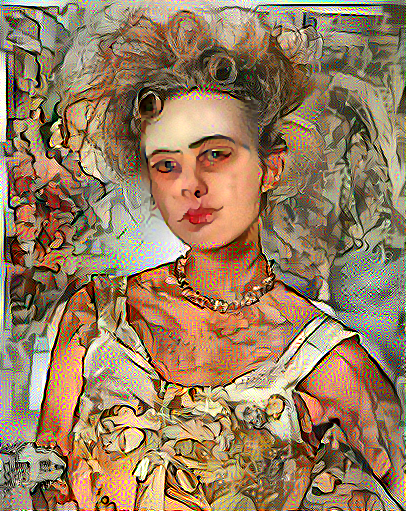

Train step: 5000


In [16]:
style_path = 'Data\\s_2_crop.png'
content_path = 'Data\\c_2_crop.png'
box = [239, 169, 198, 240]
img = convert(epochs, steps_per_epoch, content_weight, total_variation_weight, style_path, content_path, box, content_layers, style_layers)      

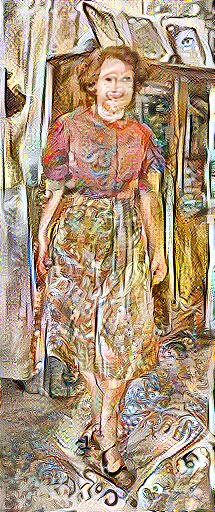

Train step: 5000


In [17]:
style_path = 'Data\\s_3_crop.png'
content_path = 'Data\\c_3_crop.png'
box = [149, 96, 58, 69]
img = convert(epochs, steps_per_epoch, content_weight, total_variation_weight, style_path, content_path, box, content_layers, style_layers)      

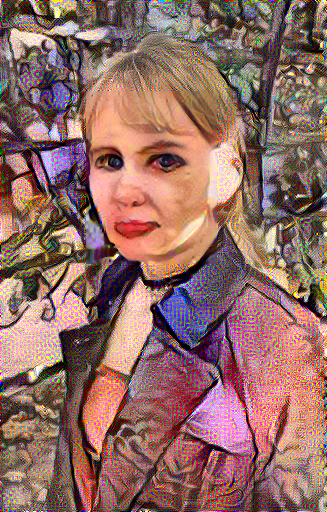

Train step: 5000


In [18]:
style_path = 'Data\\s_4_crop.png'
content_path = 'Data\\c_4_crop.png'
box = [97, 103, 147, 195]
img = convert(epochs, steps_per_epoch, content_weight, total_variation_weight, style_path, content_path, box, content_layers, style_layers)      

## Procrustes alignment

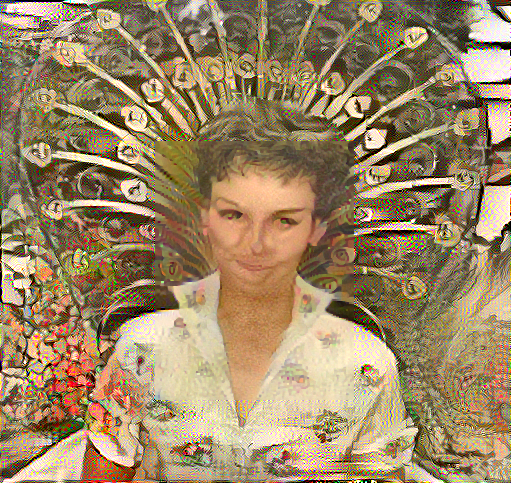

Train step: 5000


In [12]:
style_path = 'Data\\s_1_proc.png'
content_path = 'Data\\c_1_proc.png'
box = [145, 132, 186, 242]
img = convert(epochs, steps_per_epoch, content_weight, total_variation_weight, style_path, content_path, box, content_layers, style_layers)      

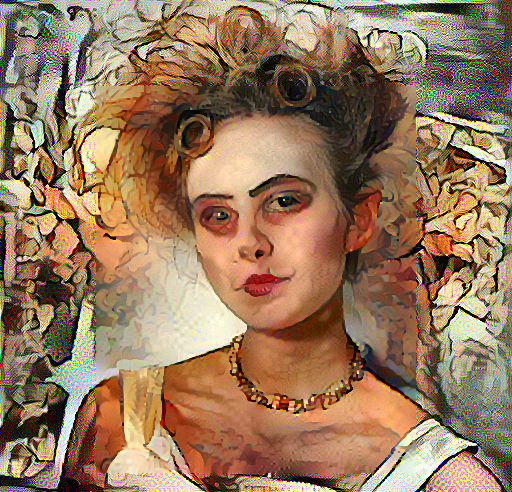

Train step: 5000


In [13]:
style_path = 'Data\\s_2_proc.png'
content_path = 'Data\\c_2_proc.png'
box = [120, 108, 400, 484]
img = convert(epochs, steps_per_epoch, content_weight, total_variation_weight, style_path, content_path, box, content_layers, style_layers)      

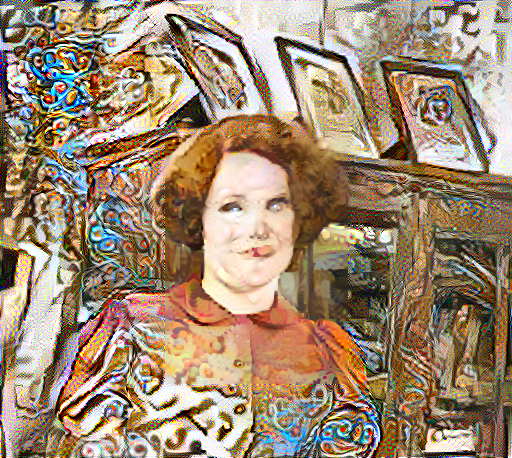

Train step: 5000


In [14]:
style_path = 'Data\\s_3_proc.png'
content_path = 'Data\\c_3_proc.png'
box = [99, 83, 110, 148]
img = convert(epochs, steps_per_epoch, content_weight, total_variation_weight, style_path, content_path, box, content_layers, style_layers)      

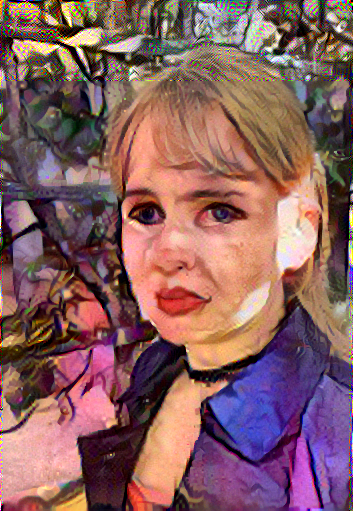

Train step: 5000


In [15]:
style_path = 'Data\\s_4_proc.png'
content_path = 'Data\\c_4_proc.png'
box = [3, 70, 296, 392]
img = convert(epochs, steps_per_epoch, content_weight, total_variation_weight, style_path, content_path, box, content_layers, style_layers)      